In [141]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import product

%matplotlib inline

In [142]:
BASE_DIR = os.getcwd()
csv_path = "sample_data/drug200.csv"

df = pd.read_csv(os.path.join(BASE_DIR, csv_path))
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [143]:
class Tree:
    def __init__(self, threshold=None, feature=None, prediction=None):
        if threshold is not None and feature is not None and prediction is None:
            self.feature = feature
            self.threshold = threshold
            self.is_leaf = False
        elif prediction is not None and threshold is None and feature is None:
            self.prediction = prediction
            self.is_leaf = True
        else:
            self.is_leaf = None
            print('Vertex in decision tree must be either predicat(only feature and threshold)'
                  'or leaf(only prediction)')

        self.right = None
        self.left = None

In [184]:
class Decision_tree:
    def __init__(self, max_depth=4, min_impurity_decrease=0.05, min_samples_leaf=5):
        self.classes = {}
        self.min_impurity_decrease = min_impurity_decrease
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.prediction = None

    def _find_classes_amount(self, y):
        classes_amount = np.zeros(len(self.classes))

        for i in y:
            classes_amount[self.classes[i]] += 1

        return classes_amount

    def _impurity_entropy(self, amount):
        impurity = 0
        probability_vector = amount / np.sum(amount)
        for i in probability_vector:
            if i != 0:
                impurity += i * np.log2(i)

        return -impurity

    def _impurity_Gini_criterion(self, amount):
        impurity = 0
        probability_vector = amount / np.sum(amount)
        for i in probability_vector:
            impurity += i * (1 - i)

        return impurity

    def _find_best_split(self, X, y):
        best_separator, best_gain, best_main_impurity = None, 0, 0

        for feature_index, feature in enumerate(X.T):
            if isinstance(feature[0], (int, float)):
                index_sorted = np.argsort(feature)

                y = y[index_sorted]
                feature = feature[index_sorted]
                n = len(feature)

                amount = self._find_classes_amount(y)
                main_impurity = self._impurity_entropy(amount)

                left, right = amount, np.zeros(len(amount))

                index = 1
                while index < n - 1:
                    label = y[index]
                    left[self.classes[label]] -= 1
                    right[self.classes[label]] += 1

                    if feature[index-1] == feature[index]:
                        index += 1
                        continue

                    left_impurity = self._impurity_entropy(left)
                    right_impurity = self._impurity_entropy(right)

                    gain = n * main_impurity - ((n - index) * left_impurity + index * right_impurity)

                    if gain > best_gain:
                        best_gain = gain
                        best_main_impurity = main_impurity
                        threshold = np.mean([feature[index - 1], feature[index]])
                        best_separator = [feature_index, index_sorted[:index], index_sorted[index:], threshold]

                    index += 1
            else:
                unique_val = np.unique(feature)
                n = len(unique_val)
                for mask in product([False, True], repeat=n):
                    if all(mask) or not any(mask):
                        continue

                    mask = np.array(mask)
                    val_mask = np.isin(feature, unique_val[mask])
                    left_mask, right_mask = val_mask, ~val_mask

                    amount = self._find_classes_amount(y)
                    main_impurity = self._impurity_entropy(amount)

                    left_amount = self._find_classes_amount(y[left_mask])
                    left_impurity = self._impurity_entropy(left_amount)

                    right_amount = self._find_classes_amount(y[right_mask])
                    right_impurity = self._impurity_entropy(right_amount)

                    left = np.sum(left_amount)
                    right = len(y) - left
                    gain = len(y) * main_impurity - (left * left_impurity + right * right_impurity)

                    if gain > best_gain:
                        best_gain = gain
                        best_main_impurity = main_impurity
                        threshold = unique_val[mask]
                        best_separator = [feature_index, left_mask, right_mask, threshold]

        return best_main_impurity, gain, best_separator

    def _is_pure(self, y):
        amount = self._find_classes_amount(y) / len(y)
        for i in amount:
            if i >= 0.95:
                return True
        return False

    def _build_tree(self, X, y, depth=0):

        probability_vector = self._find_classes_amount(y)

        stop_conditions = [
            len(y) < self.min_samples_leaf,
            depth >= self.max_depth,
            self._is_pure(y)
        ]

        if any(stop_conditions):
            return Tree(prediction=probability_vector)

        main_impurity, gain, split_criteria = self._find_best_split(X, y)

        if gain < self.min_impurity_decrease * main_impurity:
            return Tree(prediction=probability_vector)

        if split_criteria is None:
            return Tree(prediction=probability_vector)

        feature_index, left_index, right_index, threshold = split_criteria

        root = Tree(feature=feature_index, threshold=threshold)
        root.left = self._build_tree(X[left_index], y[left_index], depth + 1)
        root.right = self._build_tree(X[right_index], y[right_index], depth + 1)

        return root

    def _draw_node(self, ax, node, x, y, dx=1, dy=1):
        if node.is_leaf is False and isinstance(node.threshold, (int, float)):
            ax.text(x, y, f"X{node.feature} ≤ {node.threshold:.2f}",
                    bbox=dict(facecolor='white'),
                    ha='center', va='center')
        elif node.is_leaf is False:
            ax.text(x, y, f"X{node.feature} == {node.threshold}",
                    bbox=dict(facecolor='white'),
                    ha='center', va='center')
        elif node.is_leaf is True:
            ax.text(x, y, f"{len(self.prediction) + 1}",
                    bbox=dict(facecolor='white'),
                    ha='center', va='center')
            self.prediction.append(node.prediction)

        if node.left:
            x_left = x - dx
            y_left = y - dy
            ax.plot([x, x_left], [y, y_left], 'k-')
            self._draw_node(ax, node.left, x_left, y_left, dx/2, dy)

        if node.right:
            x_right = x + dx
            y_right = y - dy
            ax.plot([x, x_right], [y, y_right], 'k-')
            self._draw_node(ax, node.right, x_right, y_right,  dx/2, dy)

    def visualize_tree(self):
        self.prediction = []
        if self.tree:
            fig, ax = plt.subplots(figsize=(20, 8))
            self._draw_node(ax, self.tree, x=0, y=0, dx=10, dy=1)
            ax.axis('off')
            plt.show()
            for i in range(len(self.prediction)):
                print(f'{i + 1}: {self.prediction[i]}')
        else:
            print('Before visualize, tree should be train first')

    def train(self, X, y):
        index = 0
        self.target = np.unique(y)
        for i in self.target:
            self.classes[i] = index
            index += 1

        self.tree = self._build_tree(X, y)
        return self

    def predict(self, X):
        prediction = []
        for i in X:
            tree = self.tree
            while not tree.is_leaf:
                if isinstance(tree.threshold, (int, float)) and i[tree.feature] >= tree.threshold:
                    tree = tree.right
                elif type(tree.threshold) == list and i[tree.feature] in tree.threshold:
                    tree = tree.right
                else:
                    tree = tree.left
            prediction.append(self.target[np.argmax(tree.prediction)])
        return prediction

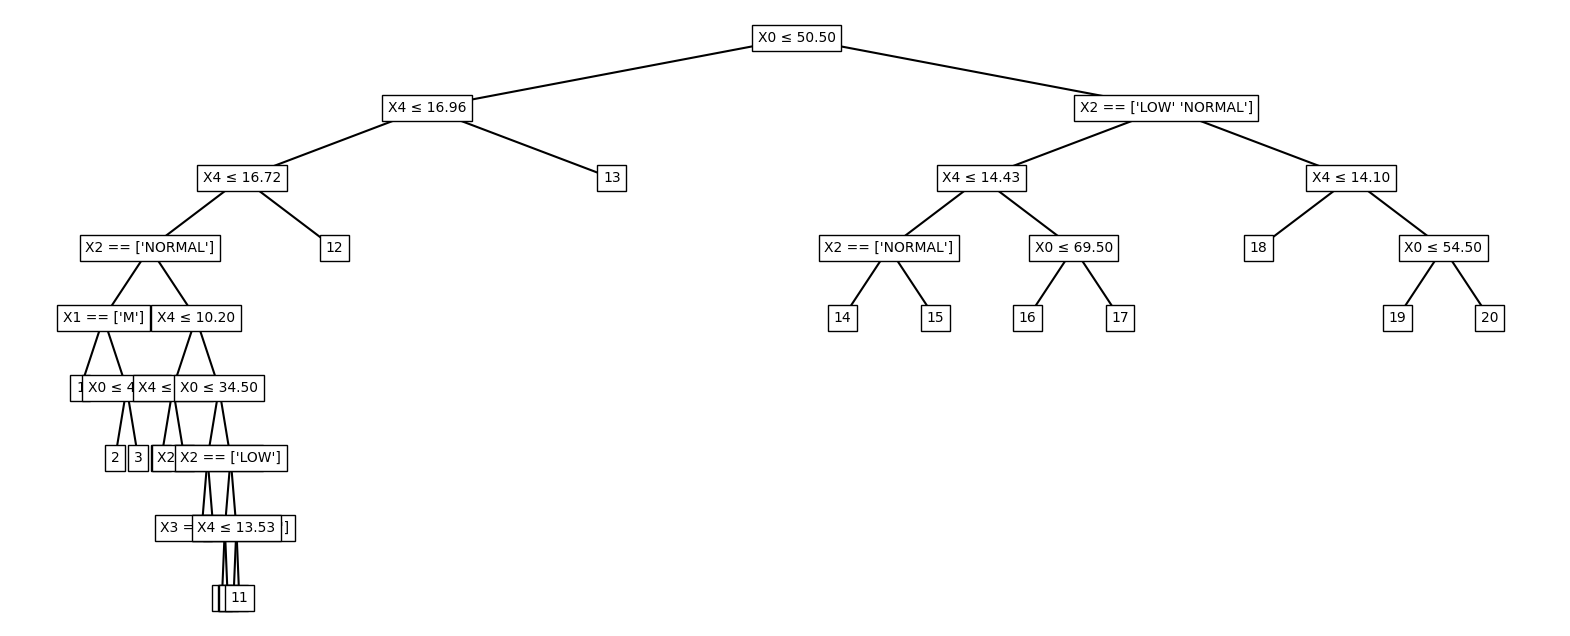

1: [0. 0. 0. 5. 2.]
2: [0. 0. 0. 7. 0.]
3: [0. 0. 0. 3. 1.]
4: [5. 0. 2. 2. 0.]
5: [1. 0. 3. 1. 0.]
6: [0. 0. 2. 3. 0.]
7: [4. 0. 0. 0. 1.]
8: [0. 0. 0. 5. 1.]
9: [0. 0. 4. 0. 2.]
10: [8. 0. 0. 0. 0.]
11: [1. 0. 0. 0. 2.]
12: [0. 0. 0. 0. 2.]
13: [ 0.  0.  0.  0. 34.]
14: [ 0.  0.  0. 11.  0.]
15: [0. 0. 4. 4. 0.]
16: [ 0.  0.  0.  0. 14.]
17: [0. 0. 0. 1. 1.]
18: [ 0. 14.  0.  0.  0.]
19: [0. 0. 0. 0. 1.]
20: [0. 1. 0. 0. 8.]
Mean F1 accuracy: 61.65792076329173


In [194]:
from sklearn.metrics import f1_score

res = 0
for i in range(100):
    df = df.sample(frac=1)
    train_data = df[:160].to_numpy()
    test_data = df[160:].to_numpy()

    m, n = train_data.shape
    X_train, y_train = train_data[:, :n-1], train_data[:, -1]

    m, n = test_data.shape
    X_test, y_test = test_data[:, :n-1], test_data[:, -1]

    a = Decision_tree(max_depth=10, min_impurity_decrease=0.05, min_samples_leaf=10)
    a.train(X_train, y_train)

    y_pred = a.predict(X_test)

    res += f1_score(y_test, y_pred, average='weighted')
a.visualize_tree()
print(f'Mean F1 accuracy: {res}')